In [16]:
# Set up the environment
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [3]:
# Load the data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Normalize the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [5]:
# Create the model
def build_model():
    # Design the model
    model = Sequential([
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    
    # Compile the model
    model.compile(
        optimizer="rmsprop",
        loss="mse",
        metrics=["mae"]
    )
    
    return model

In [12]:
# Execute a K-fold validation
k = 4
num_val_samples = len(train_data) // k
num_of_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    model = build_model()
    model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_of_epochs,
        batch_size=16,
        verbose=0
    )
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [13]:
# Observe the results
all_scores

[1.8127341270446777, 2.4694480895996094, 2.4214000701904297, 2.523707151412964]

In [14]:
# Execute an optimized version of K-fold validation
num_of_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    model = build_model()
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_of_epochs,
        batch_size=16,
        validation_data = (val_data, val_targets),
        verbose=0
    )
    val_mse, val_mae = model.evaluate(test_data, test_targets, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [15]:
# Build the history of successive K-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_of_epochs)]

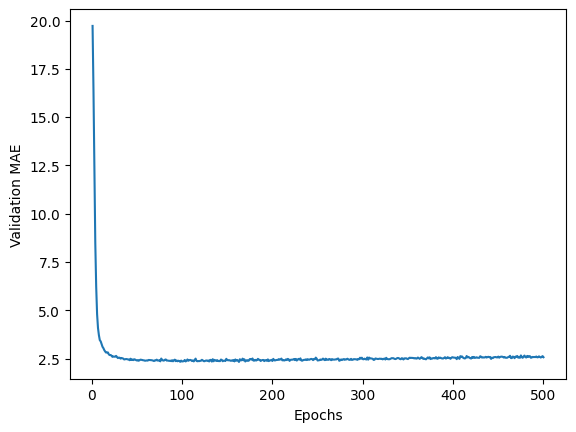

In [17]:
# Plot validation scores
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

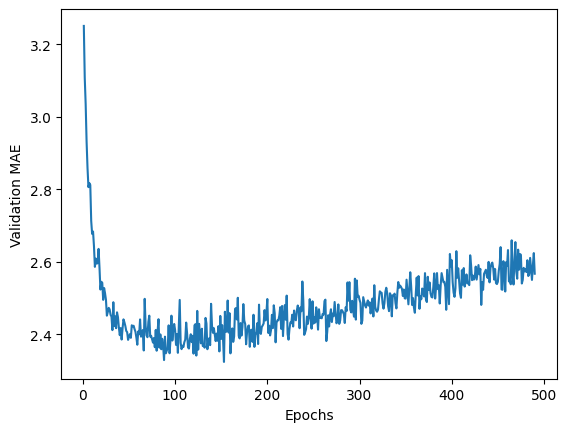

In [18]:
# Plot validation scores, excluding the first 10 data points
plt.clf()
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [19]:
# Train the final model
model = build_model()
model.fit(
    train_data,
    train_targets,
    epochs=130,
    batch_size=16,
    verbose=0
)

In [20]:
# Evaluate the results
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(f"Test MAE: {test_mae_score}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7731 - mae: 2.4020
Test MAE: 2.555690288543701
